In [17]:

import os, sys
import random
import numpy as np
import torch
import utils


In [18]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

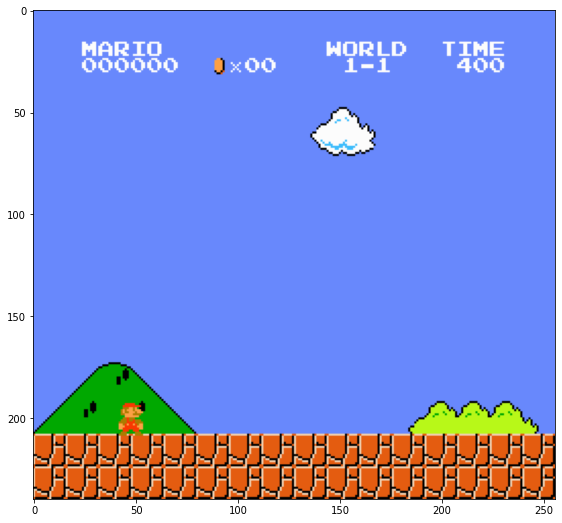

In [19]:
ENV_NAME = "SuperMarioBros-1-1-v0"

env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.reset()

env.render("rgb_array")

n_cols = 1
n_rows = 1
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [20]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessMarioObs(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.2, 0]):
        return np.dot(rgb, channel_weights)


    def observation(self, img):
        img = img[50:210]
        img = self._to_gray_scale(img)
        img = cv2.resize(img, dsize=self.img_size[1:], interpolation = cv2.INTER_AREA)
        img = img[..., np.newaxis]
        img /= np.max(img)
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        return img.astype(np.float32)


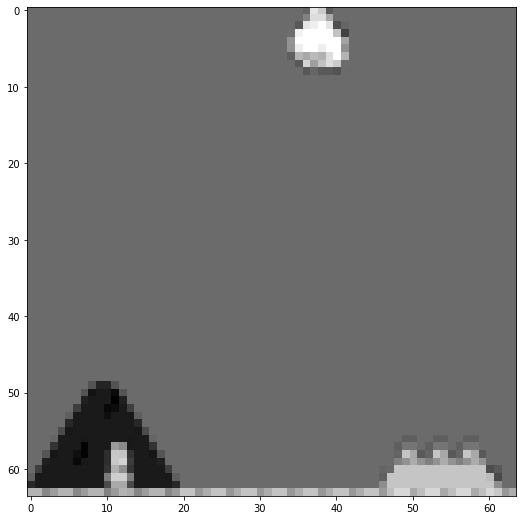

In [21]:
_cols = 1
n_rows = 1
fig = plt.figure(figsize=(16, 9))
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = PreprocessMarioObs(env)
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()


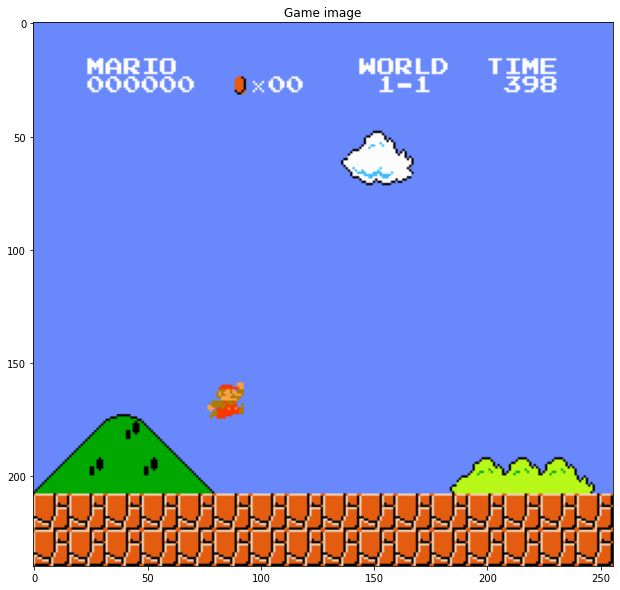

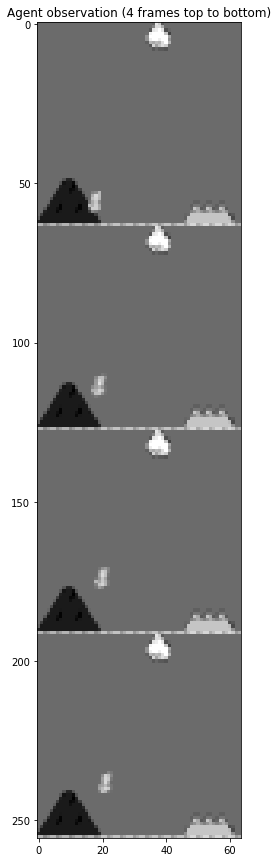

In [22]:
from framebuffer import *

def make_env(seed=None):
    env = gym_super_mario_bros.make(ENV_NAME)
    env = JoypadSpace(env, SIMPLE_MOVEMENT)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = MaxAndSkipEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = PreprocessMarioObs(env)
    # env = ImageToPyTorch(env)
    env = FrameBuffer(env, 4)
    env = NormalizeFloats(env)
    env = CustomReward(env)
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()


In [23]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device


device(type='cpu')

In [24]:
class DQNAgent(nn.Module):
    def __init__(self, input_shape, n_actions, epsilon=0):
        super(DQNAgent, self).__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1)
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        # print(conv_out.shape)
        return self.fc(conv_out)

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [25]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [26]:
evaluate(make_env(), DQNAgent(state_shape, n_actions))

-46.5000000000003

In [27]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    s = initial_state
    sum_rewards = 0

    for i in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, _ = env.step(action)
        sum_rewards += r
        exp_replay.add(s, action, r, new_s, done)
        s = new_s
        if done:
            s = env.reset()

    return sum_rewards, s



In [28]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )

    predicted_qvalues = agent(states)

    predicted_next_qvalues = target_network(next_states)

    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    next_state_values = torch.tensor([torch.max(i) for i in predicted_next_qvalues])

    target_qvalues_for_actions = rewards + gamma * next_state_values

    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    return loss


In [29]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

seed = 228
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)



In [30]:
from replay_buffer import ReplayBuffer

REPLAY_BUFFER_SIZE = 3 * 10**4
N_STEPS = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
while exp_replay.__len__() < REPLAY_BUFFER_SIZE:
    if not utils.is_enough_ram(min_available_gb=0.1):
        break
    play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))



30000


In [52]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**6
decay_steps = 5 * 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 0.15
final_epsilon = 0.05


loss_freq = 3000
refresh_target_network_freq = 3000
eval_freq = 9000

max_grad_norm = 50

# mean_rw_history = []
# td_loss_history = []
# grad_norm_history = []
# initial_state_v_history = []
step = 0



buffer size = 30000, epsilon = 0.06524


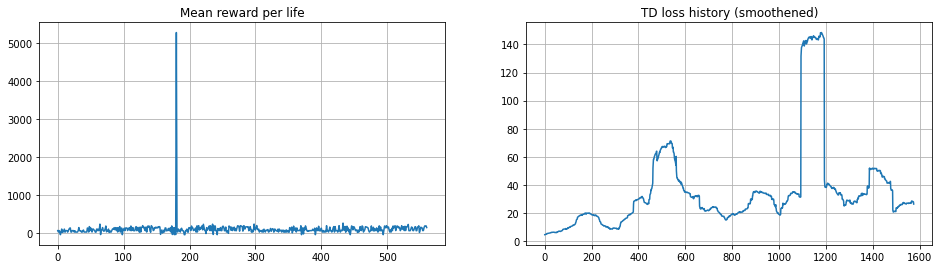

 17%|█▋        | 643647/3761088 [23:38:10<123:41:20,  7.00it/s]

In [ ]:
gamma = 0.99

env = make_env()

state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')

        agent.epsilon = utils.update_epsilon(init_epsilon, final_epsilon, step, decay_steps)
        # agent.epsilong = 0.1
        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)
        states = torch.tensor(
            states, dtype=torch.float32)    # shape: [batch_size, state_size]
        actions = torch.tensor(actions, dtype=torch.long)    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
        # shape: [batch_size, state_size]
        next_states = torch.tensor(next_states, dtype=torch.float32)
        is_done = torch.tensor(is_done, dtype=torch.uint8)
        predicted_qvalues = agent(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]
        # compute q-values for all actions in next states
        # print([torch.max(network(i)) for i in next_states])
        predicted_next_qvalues = target_network(next_states)

        # compute V*(next_states) using predicted next q-values
        next_state_values = torch.tensor([torch.max(i) for i in predicted_next_qvalues])
        assert next_state_values.dtype == torch.float32

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma * next_state_values

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        loss = torch.mean((predicted_qvalues_for_actions -
                           target_qvalues_for_actions.detach()) ** 2)
        loss.backward()
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())
        if step % eval_freq == 0:
            rew = evaluate(
                make_env(), agent, n_games=1, greedy=False)
            if rew >= 5000:
                break
            mean_rw_history.append(rew)
            initial_state_q_values = agent.get_qvalues(
                [make_env().reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()
            assert not  np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()
            plt.show()



In [62]:
env = make_env()

state = env.reset()

for i in range(10000):
    qvalues = target_network.get_qvalues([state])
    action = qvalues.argmax(axis=-1)[0]
    state, reward, done, info = env.step(action)
    if done:
        state = env.reset()
    env.render()
env.close()

KeyboardInterrupt: 

In [ ]:
torch.save(agent.state_dict(), "/Users/vaaven/PycharmProjects/scientificProject/model")

In [ ]:
model = torch.load("/Users/vaaven/PycharmProjects/scientificProject/model")

env = make_env()

state = env.reset()

for i in range(10000):
    qvalues = model.get_qvalues([state])
    action = qvalues.argmax(axis=-1)[0]
    state, reward, done, info = env.step(action)
    if done:
        state = env.reset()
    env.render()
env.close()